In [1]:
%matplotlib inline

import os
import time
import copy
import shutil
import random
import torch
import torchvision
from torchvision import *
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from PIL import *
from matplotlib import pyplot as plt
import seaborn as sns
import glob

torch.manual_seed(0)
seed = 123
random.seed(seed)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0+cu102


In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [5]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [6]:
plt.style.use("Solarize_Light2")

# Exploratory data analysis

In [7]:
covid_data = pd.read_excel('../dataset/COVID-19_Radiography_Dataset/COVID.metadata.xlsx',sheet_name = 0)
covid_data.head()

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [8]:
opacity_data = pd.read_excel('../dataset/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx',sheet_name = 0)
opacity_data.head()

,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [9]:
normal_data = pd.read_excel('../dataset/COVID-19_Radiography_Dataset/Normal.metadata.xlsx',sheet_name = 0)
normal_data.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [10]:
viral_data = pd.read_excel('../dataset/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx',sheet_name = 0)
viral_data.head()

,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


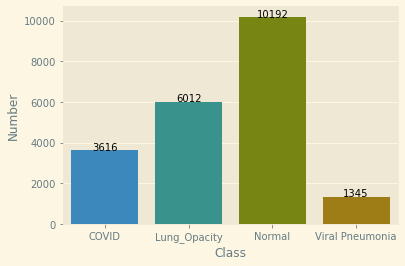

In [11]:
pathology_list = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
pathology_num = [len(covid_data), len(opacity_data), len(normal_data), len(viral_data)]

df = pd.DataFrame({"Class": pathology_list, "Number": pathology_num})

f = sns.barplot(x="Class", y="Number", data=df)

for index,row in df.iterrows():
    f.text(row.name,row.Number,row.Number,ha="center")

**show 4 images randomly from each COVID, Viral Pneumonia, and Normal**

In [12]:
plt.style.use("grayscale")

In [13]:
root_date_path = '../dataset/COVID-19_Radiography_Dataset'
class_names = ['COVID', 'Normal', 'Viral Pneumonia']

images_path_dir = {
    'COVID':f'{root_date_path}/COVID/images',
    'Normal':f'{root_date_path}/Normal/images',
    'Viral Pneumonia':f'{root_date_path}/Viral Pneumonia/images'
}

masks_path_dir = {
    'COVID':f'{root_date_path}/COVID/masks',
    'Normal':f'{root_date_path}/Normal/masks',
    'Viral Pneumonia':f'{root_date_path}/Viral Pneumonia/masks'
}

In [14]:
def show_images_random(imgs_path):
    """
    make a dictionary for lung segmentation images
    
    Parameters
    ----------
    dir_path: str
        path of source dictionary
    """
    for i, v in enumerate(imgs_path):
        if i == 0:
            img = Image.open(v)  # open image 
            img_array = np.array(img)  # transfer to np array object
        if i > 0:
            img_array2 = np.array(Image.open(v))
            img_array = np.concatenate((img_array, img_array2), axis=1)  # concatenate images by row
            # img_array = np.concatenate((img_array, img_array2), axis=0)  # concatenate images by col
            img = Image.fromarray(img_array)
    plt.axis('off')
    plt.imshow(img)
    

In [15]:
covid_images_list = [os.path.join(images_path_dir['COVID'], 'COVID-1.png'),
                     os.path.join(images_path_dir['COVID'], 'COVID-10.png'),
                     os.path.join(images_path_dir['COVID'], 'COVID-100.png'),
                     os.path.join(images_path_dir['COVID'], 'COVID-1000.png')]
viral_images_list = [os.path.join(images_path_dir['Viral Pneumonia'], 'Viral Pneumonia-1.png'),
                     os.path.join(images_path_dir['Viral Pneumonia'], 'Viral Pneumonia-10.png'),
                     os.path.join(images_path_dir['Viral Pneumonia'], 'Viral Pneumonia-100.png'),
                     os.path.join(images_path_dir['Viral Pneumonia'], 'Viral Pneumonia-1000.png')]
Normal_images_list = [os.path.join(images_path_dir['Normal'], 'Normal-5.png'),
                     os.path.join(images_path_dir['Normal'], 'Normal-58.png'),
                     os.path.join(images_path_dir['Normal'], 'Normal-508.png'),
                     os.path.join(images_path_dir['Normal'], 'Normal-2200.png')]

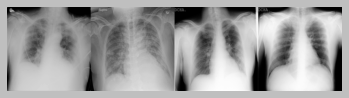

In [16]:
show_images_random(covid_images_list)
plt.savefig('four_images_COVID.png', dpi=120, bbox_inches='tight')

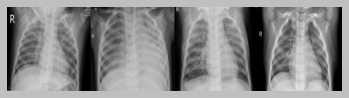

In [17]:
show_images_random(viral_images_list)
plt.savefig('four_images_viral.png',dpi=120, bbox_inches='tight')

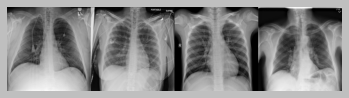

In [18]:
show_images_random(Normal_images_list)
plt.savefig('four_images_normal.png',dpi=120, bbox_inches='tight')

# Split Dataset and create dataloaders

**Make folders for Train, valid, test dataset and lung segmentation dataset**

In [19]:
def mkdir_lung_segm(dir_path, class_names):
    """
    make a dictionary for lung segmentation images
    
    Parameters
    ----------
    dir_path: str
        path of source dictionary
    class_names: dictionary 
        class names of the dataset
    """
    folder = os.path.exists(dir_path)
    set_list = ['train','valid','test']
    if not folder:
        os.mkdir(dir_path)
        for class_name in class_names:
            os.mkdir(os.path.join(dir_path,class_name))
            print(f'{os.path.join(dir_path,class_name)} creat successfully!')
    else:
        print(f'WARN: {dir_path} is already exists!') 

In [20]:
mkdir_lung_segm("../dataset/lung_segmentation_dataset", class_names)

WARN: ../dataset/lung_segmentation_dataset is already exists!


In [21]:
def mkdir_train_val_test(dir_path, class_names):
    """
    make a Dictionary for train, validation, test dataset
    
    Parameters
    ----------
    dir_path: str
        path of source dictionary
    class_names: dictionary, str
        class names of the dataset
    """
    folder = os.path.exists(dir_path)
    set_list = ['train','valid','test']
    if not folder:
        os.mkdir(dir_path)
        for set_name in set_list:
            os.mkdir(os.path.join(dir_path, set_name))
            for class_name in class_names:
                os.mkdir(os.path.join(dir_path,set_name,class_name))
                print(f'{os.path.join(dir_path,set_name,class_name)} creat successfully!')
    else:
        print(f'WARN: {dir_path} is already exists!') 

In [22]:
mkdir_train_val_test("../dataset/TrainValTest", class_names)

WARN: ../dataset/TrainValTest is already exists!


**Get lung segmentation images by ground-truth masks**

In [23]:
class LungSegment:
    """
    Get lung segmentations image by mask matting
    
    Attributes
    ----------
    image_path: str
        path of original X-Ray image
    mask_path: str
        path of lung mask
    out_path: str
        output path of lung segmentation images
    
    Methods
    -------
    matting()
        segment lung field of X-ray images by masks
    save()
        save the obtained lung Segmentation images to output
    """
    
    def __init__(self, image_path, mask_path, out_path):
        self.image = cv2.imread(image_path)   # read in image
        self.mask = cv2.imread(mask_path)    #read in mask
        self.bg = cv2.imread(mask_path)    # read in background(same as mask)
        # resize image to the size of mask
        self.image = cv2.resize(self.image, 
                               (self.mask.shape[1], self.mask.shape[0]), 
                               interpolation=cv2.INTER_AREA)   
        self.out_path = out_path
    
    def matting(self):
        bg_mask = (np.ones(self.image.shape, dtype='uint8') * 255) - self.mask 
        mask = self.mask.astype("float") 
        mask = mask / 255 
        image = self.image * mask
        bg = self.bg * (bg_mask/255) 
        image = image.astype("uint8")
        bg = bg.astype("uint8")
        self.stacked = cv2.addWeighted(image, 1, bg, 1, 0)
        
    def save(self):
        cv2.imwrite(self.out_path, self.stacked)

In [24]:
root_cov_ori = "../dataset/COVID-19_Radiography_Dataset"
dir_path = "../dataset/lung_segmentation_dataset"
input_dir = {
    'COVID':f'{root_cov_ori}/COVID',
    'Normal':f'{root_cov_ori}/Normal',
    'Viral Pneumonia':f'{root_cov_ori}/Viral Pneumonia'
}
out_dir = {
    'COVID':f'{dir_path}/COVID',
    'Normal':f'{dir_path}/Normal',
    'Viral Pneumonia':f'{dir_path}/Viral Pneumonia'
}

In [25]:
def get_lung_segmentation(input_dir, out_dir):
    
    """
    Get lung segmentation images for all X-ray images by class LungSegment
    
    Parameters
    ----------
    input_dir: dictionary, str
        path of source dictionary for X-ray and mask images
    out_dir: dictionary, str
        output path of lung segmentation images
    """
    # define an indicator empty_or_not to check the output dataset whether being created
    empty_or_not = [x for x in os.listdir(os.path.join(out_dir['COVID'])) if x.lower().endswith('png')]
    if empty_or_not == []:
        print('The seg_data is empty, start to do lung segmentation!')
        for class_name in class_names:
            mask_path = [x for x in os.listdir(os.path.join(input_dir[class_name],'masks')) if x.lower().endswith('png')]
            for i in range(len(mask_path)):
                # search the image filename by mask filename
                match_mask_path = glob.glob(os.path.join(input_dir[class_name], 'images', mask_path[i]))
                if not match_mask_path == []:
                    out_path = os.path.join(out_dir[class_name], mask_path[i])
                    # get lung segmentation image by LungSegment class
                    mm = LungSegment(os.path.join(input_dir[class_name], 'images', mask_path[i]),
                                      os.path.join(input_dir[class_name], 'masks', mask_path[i]),
                                      out_path)
                    mm.matting()
                    mm.save()
        print('Creat lung segmentation data down!')
    else:
        print('Lung segmentation data has been cearted!')

In [26]:
get_lung_segmentation(input_dir, out_dir)

Lung segmentation data has been cearted!


**Get Examples for lung segmentation dataset for each pathologys**

In [27]:
root_seg_date_path = '../dataset/lung_segmentation_dataset'

images_seg_path_dir = {
    'COVID':f'{root_seg_date_path}/COVID',
    'Normal':f'{root_seg_date_path}/Normal',
    'Viral Pneumonia':f'{root_seg_date_path}/Viral Pneumonia'
}

In [28]:
covid_seg_images_list = [os.path.join(images_seg_path_dir['COVID'], 'COVID-1.png'),
                     os.path.join(images_seg_path_dir['COVID'], 'COVID-10.png'),
                     os.path.join(images_seg_path_dir['COVID'], 'COVID-100.png'),
                     os.path.join(images_seg_path_dir['COVID'], 'COVID-1000.png')]
viral_seg_images_list = [os.path.join(images_seg_path_dir['Viral Pneumonia'], 'Viral Pneumonia-1.png'),
                     os.path.join(images_seg_path_dir['Viral Pneumonia'], 'Viral Pneumonia-10.png'),
                     os.path.join(images_seg_path_dir['Viral Pneumonia'], 'Viral Pneumonia-100.png'),
                     os.path.join(images_seg_path_dir['Viral Pneumonia'], 'Viral Pneumonia-1000.png')]
Normal_seg_images_list = [os.path.join(images_seg_path_dir['Normal'], 'Normal-5.png'),
                     os.path.join(images_seg_path_dir['Normal'], 'Normal-52.png'),
                     os.path.join(images_seg_path_dir['Normal'], 'Normal-527.png'),
                     os.path.join(images_seg_path_dir['Normal'], 'Normal-2192.png')]

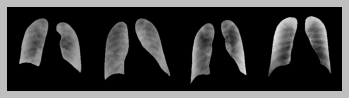

In [29]:
show_images_random(covid_seg_images_list)
plt.savefig('four_lung_seg_images_COVID.png', dpi=120, bbox_inches='tight')

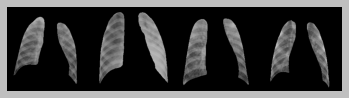

In [30]:
show_images_random(viral_seg_images_list)
plt.savefig('four_lung_seg_images_viral.png', dpi=120, bbox_inches='tight')

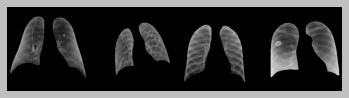

In [31]:
show_images_random(Normal_seg_images_list)
plt.savefig('four_lung_seg_images_normal.png', dpi=120, bbox_inches='tight')

**divide lung segmentation dataset into train, valid, test dataset**

In [32]:
def divideTrainValiTest(source_path, target_path, class_names):
    """
    divid Original dataset into Train,Valid and Test dataset with ratio 8:1:1
    Parameters
    ----------
    source_path: str
        path of original dataset
    target_path: str
        path of output folder
    class_names: dictionary, str
        a dictionary to store class names of the original dataset
    """
    if os.listdir(os.path.join(target_path, 'train', 'COVID')):
        print("The TrainValiTest has been created already!")
        return True
    
    # Operate on the data in each category
    for class_name in class_names:
        # Get the name of this type of picture
        image_names = [x for x in os.listdir(os.path.join(source_path,class_name)) if x.lower().endswith('png')]
        # shuffle the order for read-in images  
        random.shuffle(image_names)
        # sample subset of image labeled with "Normal"
        if (class_name == 'Normal'):
            print(int(len(covid_data)+len(viral_data)-1))
            image_names = image_names[0:int(len(covid_data)+len(viral_data)-1)]
            
        # Divide the train, valid, test dataset by 8:1:1
        train_list = image_names[0:int(0.8 * len(image_names))]
        valid_list = image_names[int(0.8 * len(image_names)):int(0.9 * len(image_names))]
        test_list = image_names[int(0.9 * len(image_names)):]
        
        # For each image, move it to the corresponding folder
        for train_pic in train_list:
            shutil.copyfile(source_path + '/' + class_name + '/'  + train_pic, 
                            target_path + '/train/' + class_name + '/' + train_pic)
        for validation_pic in valid_list:
            shutil.copyfile(source_path + '/' + class_name + '/' + validation_pic,
                            target_path + '/valid/' + class_name + '/' + validation_pic)
        for test_pic in test_list:
            shutil.copyfile(source_path + '/' + class_name + '/' + test_pic, 
                            target_path + '/test/' + class_name + '/' + test_pic)
    print("The TrainValiTest creates Successfully! ")

In [33]:
target_path = "../dataset/TrainValTest"
divideTrainValiTest("../dataset/lung_segmentation_dataset", target_path, class_names)

The TrainValiTest has been created already!


True

**Data Augmentation**

In [34]:
# We resize all images in Train and Valid dataset to 224 by 224.
# We apply rotation transformation from 0-15 degree, 
# filp images randomly with probability 0.1 for Train dataset.
# Normalize each images in Train, Valid dataset. 
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(15, expand=False),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

**dataloaders**

In [35]:
def make_weights_for_balanced_classes(images, nclasses):
    """
    create a weighted random sampler for Train dataset
    
    Parameters
    ----------
    images: ImageFolder object
        One Image Folder of Pytorch to store train dataset
    nclasses: int
        number of classes
    
    Returns
    -------
    weights: list
        a list of float numbers for sampling weights
    """
    n_images = len(images)
    count_per_class = [0] * nclasses
    for _, image_class in images:
        count_per_class[image_class] += 1
    weight_per_class = [0.] * nclasses
    for i in range(nclasses):
        weight_per_class[i] = float(n_images) / float(count_per_class[i])
    weights = [0] * n_images
    for idx, (image, image_class) in enumerate(images):
        weights[idx] = weight_per_class[image_class]
    return weights

In [36]:
data_dir = "../dataset/TrainValTest"

# collect data into ImageFolder
dataset_train = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
dataset_valid = datasets.ImageFolder(os.path.join(data_dir, 'valid'), data_transforms['valid'])
dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'))
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 
# Load data into DataLoader
dataloaders = { 'train':torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle = False,                              
                                        sampler = sampler, num_workers=2, pin_memory=False),
                'valid':torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle = True, 
                                        num_workers=2, pin_memory=False)}


In [37]:
def get_each_class_distribution(data_dir, class_names):
    """
    get sample distribution for each class in train, valid, test dataset
    
    Parameters
    ----------
    data_dir: str
        path for Train, Validation, Test dataset
    class_names: dictionary, str
        the class name of original dataset
        
    Returns
    -------
    distribution: dictionary, dictionary, int
        a dictionary to store the sample distribution for each class in train, valid, test dataset
    """
    
    train_val_test = ['train', 'valid','test']
    distribution = {
        'train':{
            'COVID':0,
            'Viral Pneumonia':0,
            'Normal':0
        },
        'valid':{
            'COVID':0,
            'Viral Pneumonia':0,
            'Normal':0
            
        },
        'test':{
            'COVID':0,
            'Viral Pneumonia':0,
            'Normal':0
            
        }
    }
    for name in train_val_test:
        for class_name in class_names:
            imgs_path = [x for x in os.listdir(os.path.join(data_dir,name,class_name)) if x.lower().endswith('png')]
            distribution[name][class_name] = len(imgs_path)
    return distribution

In [38]:
distribution = get_each_class_distribution(data_dir, class_names)
print(distribution)

{'train': {'COVID': 2892, 'Viral Pneumonia': 1076, 'Normal': 3968}, 'valid': {'COVID': 362, 'Viral Pneumonia': 134, 'Normal': 496}, 'test': {'COVID': 362, 'Viral Pneumonia': 135, 'Normal': 496}}


In [39]:
dataset_sizes = {
    'train':len(dataset_train),
    'valid':len(dataset_valid),
    'test':len(dataset_test)
}
print(dataset_sizes)

{'train': 7936, 'valid': 992, 'test': 993}


**Show images after data augmentation**

In [40]:
def show_images(images, labels, preds):
    """
    plot the predict results for each batch, 
    the batch size should less than 7 to get a best visualization results
    
    Parameters
    ----------
    images: ImageFolder object
        One Image Folder of Pytorch to store train dataset
    labels: tensor, int
        the true label for each image sample
    preds: tensor, int
        the predict label for each image sample
    """
    plt.figure(figsize=(10, 8))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        # Normalize images
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

In [41]:
images, labels = next(iter(dataloaders['train']))
# show_images(images, labels, labels)

# Train Lung segmentation Dataset by ResNet50

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=True)

# Freeze the layer you want 
# ct = 0
# for child in resnet50.children():
#     ct += 1
#     if ct < 10:
#         if ct == 7:
#             continue
#         for param in child.parameters():
#             param.requires_grad = False

# define the last full connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
                            nn.Dropout(p=0.5),
                            nn.Linear(2048, 2048),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(2048, 2048),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=num_ftrs, out_features=3))
# define Loss function, optimizer and model on GPU
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet50.parameters()), lr=3e-5)
resnet50 = resnet50.cuda() if device else resnet50

In [43]:
def show_preds():
    """
    show prediction of validation images for one batch
    """
    resnet50.eval()   # change model mode to evaluation 
    images, labels = next(iter(dataloaders['valid']))
    if device:
        images, labels = images.cuda(), labels.cuda()
    outputs = resnet50(images)   # obtain score of the image by model 
    _, preds = torch.max(outputs, 1)   # obtain the predicted class index
    show_images(images.cpu(), labels.cpu(), preds.cpu())

In [44]:
# show_preds()

In [45]:
def train_model(model, criterion, optimizer, num_epochs=1):
    """
    Train the proposed Reset50 network
    
    Parameters
    ----------
    model: model object
        the choosen deep learning model
    criterion: nn object
        the choosen loss funtion 
    optimizer: optim object
        the choosen optimizer
    num_epochs: int, optional
        the numer of epoch
        
    Returns
    -------
    model: model object
        model parameters after training
    loss_hist: dictionary, list, float
        loss value of train and valid for each epoch
    acc_hist: tensor, float
        accurancy value of train and valid for each epoch
    """
    loss_hist = {
        'train':[],
        'valid':[]
    }
    acc_hist = {
        'train':[],
        'valid':[]
    }
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            # add acc and loss to list for one epoch
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_hist, acc_hist

In [46]:
resnet50_drop_subset_50 ,loss_hist, acc_hist = train_model(resnet50, loss_fn, optimizer, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4174 Acc: 0.8280
valid Loss: 0.2446 Acc: 0.9073
Epoch 1/49
----------
train Loss: 0.2043 Acc: 0.9173
valid Loss: 0.2241 Acc: 0.9143
Epoch 2/49
----------
train Loss: 0.1750 Acc: 0.9316
valid Loss: 0.1642 Acc: 0.9395
Epoch 3/49
----------
train Loss: 0.1441 Acc: 0.9448
valid Loss: 0.2316 Acc: 0.9123
Epoch 4/49
----------
train Loss: 0.1330 Acc: 0.9496
valid Loss: 0.1231 Acc: 0.9577
Epoch 5/49
----------
train Loss: 0.1068 Acc: 0.9602
valid Loss: 0.2092 Acc: 0.9325
Epoch 6/49
----------
train Loss: 0.0921 Acc: 0.9665
valid Loss: 0.1240 Acc: 0.9657
Epoch 7/49
----------
train Loss: 0.0881 Acc: 0.9686
valid Loss: 0.1578 Acc: 0.9496
Epoch 8/49
----------
train Loss: 0.0992 Acc: 0.9627
valid Loss: 0.1028 Acc: 0.9667
Epoch 9/49
----------
train Loss: 0.0756 Acc: 0.9728
valid Loss: 0.1227 Acc: 0.9597
Epoch 10/49
----------
train Loss: 0.0780 Acc: 0.9728
valid Loss: 0.1073 Acc: 0.9657
Epoch 11/49
----------
train Loss: 0.0679 Acc: 0.9752
valid Loss: 0.0814 Ac

**Save ResNet50 Model**

In [48]:
torch.save(resnet50_drop_subset_50.state_dict(), 'resnet50_covid_classifier_seg_epch_32_drop_subset_batch32.pt')

**Predict results in test dataset**

In [49]:
# Load the model and set in eval
resnet50 = torchvision.models.resnet50(pretrained=True)
# define the last fully connected layer
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
                            nn.Dropout(p=0.5),
                            nn.Linear(2048, 2048),
                            nn.ReLU(inplace=True),
                            nn.Dropout(p=0.5),
                            nn.Linear(2048, 2048),
                            nn.ReLU(inplace=True),
                            nn.Linear(in_features=num_ftrs, out_features=3))

# load in trainded model weights
resnet50.load_state_dict(torch.load('resnet50_covid_classifier_seg_epch_32_drop_subset_batch32.pt'))
# model calculated on GPU
resnet50 = resnet50.cuda() if device else resnet50
# change the mode of model to evaluation
resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
# show_preds()

In [51]:
def predict_image_class(image_path, model):
    """
    predict image label in test dataset
    
    Parameters
    ----------
    image_path: str
        the path of test dataset
    model: model object
        the trained model
        
    Returns
    -------
    probabilities: float
        predicted probability for input images
    predicted_class_index: int
        predicted class index for input images
    predicted_class_name: str
        predicted class name for input images
    """
        
    image = Image.open(image_path).convert('RGB')
    image = data_transforms['valid'](image)
    image = image.cuda()
    # Please note that the transform is defined already in a previous code cell
    image = image.unsqueeze(0)
    output = model(image)[0]    # evaluate score by trained model
    probabilities = torch.nn.Softmax(dim=0)(output)    # transfer score by softmax to probability
    probabilities = probabilities.cpu().detach().numpy() 
    predicted_class_index = np.argmax(probabilities)   # predict the class index by the maximum probability
    predicted_class_name = class_names[predicted_class_index]   # get class name by class index
    return probabilities, predicted_class_index, predicted_class_name

In [52]:
# one eample to test the predict_image_class function
image_path = '../dataset/TrainValTest/test/COVID/COVID-7.png'
probabilities, predicted_class_index, predicted_class_name = predict_image_class(image_path, resnet50)
print('Probabilities:', probabilities)
print('Predicted class index:', predicted_class_index)
print('Predicted class name:', predicted_class_name)

Probabilities: [9.9546129e-01 4.5311130e-03 7.5935604e-06]
Predicted class index: 0
Predicted class name: COVID


# Performance Evaluation

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [58]:
pred_vect = []
y_pred = []
y_true = []
test_dir = '../dataset/TrainValTest/test'
for c in class_names:
    images = [x for x in os.listdir(os.path.join(test_dir, c)) if x.lower().endswith('png')]
    for i in range(len(images)):
        image_path = os.path.join(test_dir, c, images[i])
        _, predicted_class_index, _ = predict_image_class(image_path, resnet50)
        y_pred.append(predicted_class_index)
        y_true.append(class_names.index(c))
        if class_names[predicted_class_index] == c:
            pred_vect.append(1)
        else:
            pred_vect.append(0)
zeros = np.zeros(len(pred_vect))
accuracy = np.mean(pred_vect != zeros)
print(f'overall accuracy: {accuracy} ')
# print(y_pred[1:10])
# print(y_true[1:10] == y_pred[1:10])

overall accuracy: 0.9768378650553877 


**Get Classificatin report for ResNet50 of Lung Segmentation Dataset**

In [59]:
from sklearn.metrics import classification_report

In [60]:
print(classification_report(y_true, y_pred, target_names=class_names, digits = 4))

                 precision    recall  f1-score   support

          COVID     0.9779    0.9779    0.9779       362
         Normal     0.9798    0.9758    0.9778       496
Viral Pneumonia     0.9635    0.9778    0.9706       135

       accuracy                         0.9768       993
      macro avg     0.9737    0.9772    0.9754       993
   weighted avg     0.9769    0.9768    0.9768       993



**Get Confusion Matrix to get Sensitivity and specificity**

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
confusion_matrix(y_true, y_pred)

array([[354,   7,   1],
       [  8, 484,   4],
       [  0,   3, 132]])

In [63]:
plt.style.use("seaborn")

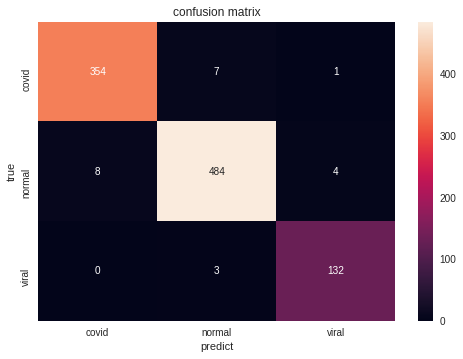

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111)
conf_mat = confusion_matrix(y_true, y_pred)
sn.heatmap(conf_mat,fmt='.20g',annot=True,xticklabels=['covid','normal','viral'],yticklabels=['covid','normal','viral']) #画热力图
ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true') 
plt.savefig('confusion_matrix.png')
plt.show()

**Plot the loss curve and accuracy curve for train and validation**

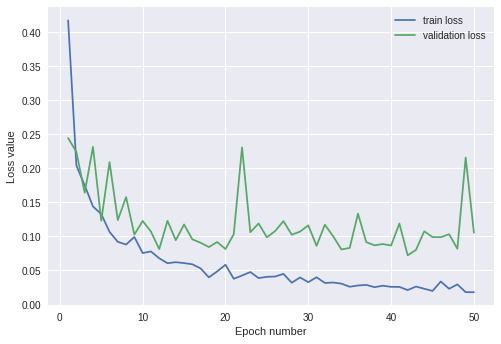

In [65]:
epoch_list = np.linspace(1, 50, 50)
l1 = plt.plot(epoch_list,loss_hist['train'], label='train loss')
l2 = plt.plot(epoch_list,loss_hist['valid'], label='validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss value')
plt.legend()
plt.savefig('train_valid_loss_curve_every_epoch.png')

In [71]:
# change tensor to list 
acc_hist_np = {
    'train':[],
    'valid':[]
}
phase = ['train','valid']
for pha in phase:
    for acc in acc_hist[pha]:
        acc_hist_np[pha].append(acc.cpu().numpy())

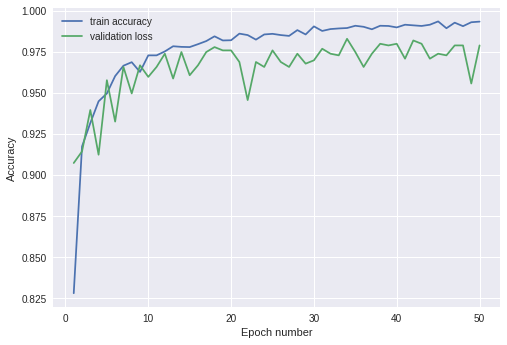

In [72]:
epoch_list = np.linspace(1, 50, 50)
l1 = plt.plot(epoch_list,acc_hist_np['train'], label='train accuracy')
l2 = plt.plot(epoch_list,acc_hist_np['valid'], label='validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('train_valid_acc_curve_every_epoch.png')